In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['POS_CASH_balance.csv', 'bureau_balance.csv', 'application_train.csv', 'previous_application.csv', 'installments_payments.csv', 'credit_card_balance.csv', 'sample_submission.csv', 'application_test.csv', 'bureau.csv']


In [4]:
# Reading the main data file "application_train/test.csv" for baseline model
train_data = pd.read_csv("../input/application_train.csv")
print('training data shape: ', train_data.shape)

test_data = pd.read_csv("../input/application_test.csv")
print('testing data shape: ', test_data.shape)

training data shape:  (307511, 122)
testing data shape:  (48744, 121)


In [5]:
# Looking at different features in training data
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Looking at overall statistics of training data
train_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,

Here are the observations from the first look at data - 

1. There are few columns with object type - need to change into categorical data
2. There are many columns with missing values - need to fix it
3. There are few columns with high standard deviation - need to normalize the data

### Examine the Distribution of the Target Column
The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [7]:
#Lets first drop the target column from the train data
target = train_data['TARGET']
#train_data = train_data.drop(columns = ['TARGET'])
#print('training data shape: ', train_data.shape)

In [8]:
# Lets look the the target distribution in the data set
target.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

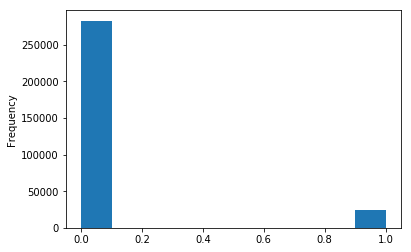

In [9]:
# Now plot the histogram to visualize it further
target.plot.hist()

Here we observe that it is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid.

### Column Types
Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features. .

In [10]:
train_data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### Encoding Categorical Variables
Before we go any further, we need to deal with these categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

1. Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created.

2. One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.
The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by PCA or other dimensionality reduction methods to reduce the number of dimensions.

### One Hot Encoding for all categorical data

In [11]:
# Utility function to change Object type training data to categorical data
def one_hot_encoding(train_data, test_data):
    """
    examine columns with object type in training and test data
    do one hot encoding of such columns
    """

    encoded_train_data = pd.get_dummies(train_data)
    encoded_test_data = pd.get_dummies(test_data)
    return encoded_train_data, encoded_test_data

In [12]:
encoded_train_data, encoded_test_data = one_hot_encoding(train_data, test_data)
print('Training Features shape after one hot encoding: ', encoded_train_data.shape)
print('Testing Features shape after one hot encoding: ', encoded_test_data.shape) 

Training Features shape after one hot encoding:  (307511, 246)
Testing Features shape after one hot encoding:  (48744, 242)


### Aligning Training and Testing Data
There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

In [13]:
align_train_data, align_test_data = encoded_train_data.align(encoded_test_data, join = 'inner', axis = 1)
align_train_data['TARGET'] = target
print('Training Features shape: ', align_train_data.shape)
print('Testing Features shape: ', align_test_data.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 242)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try dimensionality reduction (removing features that are not relevant) to reduce the size of the datasets.

### Examine Missing Values
Now we will examine the columns with missing values

In [14]:
missing_val_count_by_column = align_train_data.isnull().sum()
missing_val_count_by_column = missing_val_count_by_column[missing_val_count_by_column > 0]
print('Number of columns with missing values: ', missing_val_count_by_column.shape[0])
missing_val_count_by_column.head()

Number of columns with missing values:  61


AMT_ANNUITY            12
AMT_GOODS_PRICE       278
OWN_CAR_AGE        202929
CNT_FAM_MEMBERS         2
EXT_SOURCE_1       173378
dtype: int64

When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

### Back to Exploratory Data Analysis
Lets look at the statistics of columns again to have a deeper look of training data and identify all important features

In [15]:
align_train_data.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,...,0.007014,0.001288,0.000276,0.005889,0.028919,0.010559,0.006419,0.124913,0.005122,0.001876,0.001132,0.006179,0.011356,0.000208,0.000159,0.002052,0.025466,0.000654,0.007167,0.003860,0.017554,0.004315,0.180072,0.018494,0.018273,0.240089,0.039283,0.489423,0.004875,0.003941,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570,0.080729
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3

In [16]:
align_test_data.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,16432.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,...,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,-3051.712949,11.786027,0.999979,0.809720,0.204702,0.998400,0.263130,0.162646,2.146767,2.038159,2.012596,12.007365,0.018833,0.055166,0.042036,0.077466,0.224664,0.174216,0.501180,0.518021,0.500106,0.122388,0.090065,0.978828,0.751137,0.047624,0.085168,0.151777,0.233706,0.238423,...,0.009047,0.006032,0.001477,0.000246,0.005826,0.026403,0.009683,0.006996,0.121451,0.006196,0.001949,0.001313,0.004965,0.011858,0.000287,0.000185,0.002503,0.026731,0.000718,0.009191,0.003570,0.018136,0.004534,0.190259,0.018731,0.018874,0.248728,0.040826,0.505888,0.005375,0.004185,0.029296,0.007242,0.005929,0.005826,0.231187,0.214057,0.016289,0.537071,0.007303
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,1569.276709,11.462889,0.004529,0.392526,0.403488,0.039971,0.440337,0.369046,0.890423,0.522694,0.515804,3.278172,0.135937,0.228306,0.200673,0.267332,0.417365,0.379

Here we obsereve that few features have negative mean values which looks suspective. This might be a sign of data anomalies.
Below are the features we need to look at - 

In [17]:
col_with_mean = align_train_data.mean(axis = 0)
col_with_negative_mean = col_with_mean[col_with_mean < 0]
col_with_negative_mean

DAYS_BIRTH               -16036.995067
DAYS_REGISTRATION         -4986.120328
DAYS_ID_PUBLISH           -2994.202373
DAYS_LAST_PHONE_CHANGE     -962.858788
dtype: float64

It seems all the days are past number of days relative to the present day when loan application is registered. We are just going to change it in years to find the age of applicants.

In [18]:
col_name_with_negative_mean = ['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']
align_train_data[col_name_with_negative_mean] = align_train_data[col_name_with_negative_mean]/-365
align_test_data[col_name_with_negative_mean] = align_test_data[col_name_with_negative_mean]/-365
align_train_data.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,43.936973,63815.045904,13.660604,8.203294,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,...,0.007014,0.001288,0.000276,0.005889,0.028919,0.010559,0.006419,0.124913,0.005122,0.001876,0.001132,0.006179,0.011356,0.000208,0.000159,0.002052,0.025466,0.000654,0.007167,0.003860,0.017554,0.004315,0.180072,0.018494,0.018273,0.240089,0.039283,0.489423,0.004875,0.003941,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570,0.080729
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,11.956133,141275.766519,9.651743,4.135481,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.

Age looks reasonable now. If we look at the DAYS_EMPLOYED column, it seems very unreasonable. The maximum number is close to 1000 years.

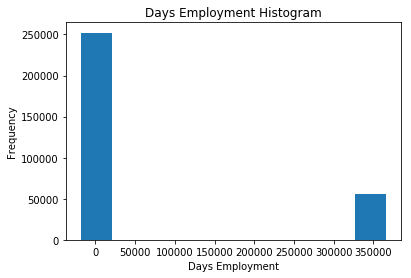

In [19]:
import matplotlib.pyplot as plt
align_train_data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Here we go..
We have bunch of entries which seems unreasonable. We have to remove those. Lets consider the maximum age of the person who is applying is 100.

In [20]:
col_with_anom = align_train_data['DAYS_EMPLOYED'] >= 36500
print('Number of anomalies : ', col_with_anom.sum())
align_train_data['DAYS_EMPLOYED'][col_with_anom].value_counts()

Number of anomalies :  55374


365243    55374
Name: DAYS_EMPLOYED, dtype: int64

Here we see that all the anomalies are subjected to only one number - 365243. We will replace this number to NaN.

In [21]:
# Replace the anomalous values with nan
align_train_data['DAYS_EMPLOYED'].replace({365243 : np.nan}, inplace=True)
align_test_data['DAYS_EMPLOYED'].replace({365243 : np.nan}, inplace=True)
align_train_data['DAYS_EMPLOYED'].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

As usual, the day counts are negative since it is relative to the date of load application. Let's make it postitive for better visualization.

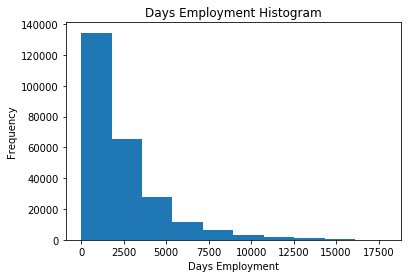

In [22]:
align_train_data['DAYS_EMPLOYED'] = abs(align_train_data['DAYS_EMPLOYED'])
align_test_data['DAYS_EMPLOYED'] = abs(align_test_data['DAYS_EMPLOYED'])

#Now plot histogram to visualize days of employment distribution
align_train_data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

### Correlation
Now we will look at the correlation of these features with target value in training dataset...

In [23]:
correlations = align_train_data.corr()['TARGET'].sort_values()
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
CODE_GENDER_M                                        0.054713
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

We have all the feature correlation with the target. We are going to consider only those features whose abs correlation is more than 0.7.
So, below are the features we are going to consider for our model - 
1. EXT_SOURCE_3/2/1
2. DAYS_BIRTH
3. DAYS_EMPLOYED

In [24]:
feature_col = ['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','DAYS_BIRTH','DAYS_EMPLOYED']
X = align_train_data[feature_col]
Y = align_train_data['TARGET']
X_test = align_test_data[feature_col]
print('Training Features shape : ', X.shape)
print('Testing Features shape : ', X_test.shape) 

Training Features shape :  (307511, 5)
Testing Features shape :  (48744, 5)


In [25]:
# have a final look at train  data to check if we miss something
X.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_EMPLOYED
count,246546.000000,3.068510e+05,134133.000000,307511.000000,252137.000000
mean,0.510853,5.143927e-01,0.502130,43.936973,2384.169325
std,0.194844,1.910602e-01,0.211062,11.956133,2338.360162
min,0.000527,8.173617e-08,0.014568,20.517808,0.000000
25%,0.370650,3.924574e-01,0.334007,34.008219,767.000000
50%,0.535276,5.659614e-01,0.505998,43.150685,1648.000000
75%,0.669057,6.636171e-01,0.675053,53.923288,3175.000000
max,0.896010,8.549997e-01,0.962693,69.120548,17912.000000


In [26]:
# have a final look at test data to check if we miss something
X_test.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,DAYS_EMPLOYED
count,40076.000000,48736.000000,28212.000000,48744.000000,39470.000000
mean,0.500106,0.518021,0.501180,44.022150,2476.738941
std,0.189498,0.181278,0.205142,11.851782,2307.963913
min,0.000527,0.000008,0.013458,20.104110,1.000000
25%,0.363945,0.408066,0.343695,34.235616,861.000000
50%,0.519097,0.558758,0.506771,43.246575,1765.000000
75%,0.652897,0.658497,0.665956,53.800000,3328.750000
max,0.882530,0.855000,0.939145,69.027397,17463.000000


### Handling Missing value

In [27]:
# Utility functions to fix missing values    
def impute_missing_values(train_data, test_data):
    """
    check for the missing values and impute it with mean values of the columns
    in both train and test data
    """
    from sklearn.preprocessing import Imputer
    imputer = Imputer(strategy = 'median')
    imputed_train_data = imputer.fit_transform(train_data)
    imputed_test_data = imputer.transform(test_data)
    return imputed_train_data, imputed_test_data


In [28]:
#impute the missing values
X, X_test = impute_missing_values(X, X_test)
print('training data shape after imputing missing values: ', X.shape)
print('testing data shape after imputing missing values: ', X_test.shape)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


training data shape after imputing missing values:  (307511, 5)
testing data shape after imputing missing values:  (48744, 5)


### Normalize tarining and test data

In [29]:
# Utility functions to normalize data   
def normalize_values(train_data, test_data):
    """
    Normalizing the feature data values using MinMaxScaler library 
    in both train and test data
    """
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range = (0, 1)) 
    normalized_train_data = scaler.fit_transform(train_data)
    normalized_test_data = scaler.transform(test_data)
    return normalized_train_data, normalized_test_data

In [30]:
#normalize data
X, X_test = normalize_values(X, X_test)
print('training data shape after normalizing values: ', X.shape)
print('testing data shape after normalizing values: ', X_test.shape)

training data shape after normalizing values:  (307511, 5)
testing data shape after normalizing values:  (48744, 5)


### Creating improved model
1. Random forest - To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.
2. XGBoost

In [39]:
#Utility function to create logistic regression model
import time   
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
    
def create_random_forest_model(X, Y):
    """
    split data into training and validation data, for both features and target
    The split is based on a random number generator. Supplying a numeric value to
    the random_state argument guarantees we get the same split every time we
    run this script.
    
    create model using sklearn random forest library and measuere model performance
    """

    print('Starting random forest model training...')
    t0 = time.time()
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state = 0, test_size=0.2)

    # Make the random forest classifier
    model = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

    # Train on the training data
    model.fit(X_train, Y_train)
    
    accuracy = model.score(X_val, Y_val)
    print('Accuray of random forest model is : ', accuracy)
    
    Y_pred = model.predict(X_val)
    mae = mean_absolute_error(Y_val, Y_pred)
    print('mean absoute error of random forest model is : ', mae)
    
    t1 = time.time()
    print('Time elapsed during random forest model training is : ', t1-t0)
    
    return model

In [40]:
# create logistic regression model
random_forest_model = create_random_forest_model(X,Y)

Starting random forest model training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Accuray of random forest model is :  0.9194185649480513


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s


mean absoute error of random forest model is :  0.08058143505194869
Time elapsed during random forest model training is :  30.69065499305725


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


In [47]:
from xgboost import XGBRegressor

def create_xgboost_model(X, Y):
    """
    split data into training and validation data, for both features and target
    The split is based on a random number generator. Supplying a numeric value to
    the random_state argument guarantees we get the same split every time we
    run this script.
    
    create model using xgboost library and measuere model performance
    """

    print('Starting xgboost model training...')
    t0 = time.time()
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state = 0, test_size=0.2)

    # Make the random forest classifier
    model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

    # Train on the training data
    model.fit(X_train, Y_train, early_stopping_rounds=5, eval_set=[(X_val, Y_val)], verbose=False)
    
    accuracy = model.score(X_val, Y_val)
    print('Accuray of xgboost model is : ', accuracy)
    
    Y_pred = model.predict(X_val)
    mae = mean_absolute_error(Y_val, Y_pred)
    print('mean absoute error of xgboost model is : ', mae)
    
    t1 = time.time()
    print('Time elapsed during xgboost model training is : ', t1-t0)
    
    return model

In [48]:
#xgboost_model = create_xgboost_model(X,Y)

Starting xgboost model training...


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Accuray of xgboost model is :  0.06205045990319381
mean absoute error of xgboost model is :  0.13841220105500493
Time elapsed during xgboost model training is :  26.303950309753418


Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model predict.proba method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

In [49]:
# generate the prediction for test data
# Make sure to select the second column only
random_forest_pred = random_forest_model.predict_proba(X_test)[:,1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


The predictions must be in the format shown in the sample_submission.csv file, where there are only two columns: SK_ID_CURR and TARGET. We will create a dataframe in this format from the test set and the predictions called submit.

In [50]:
# Submission dataframe
submit = align_test_data[['SK_ID_CURR']]
submit['TARGET'] = random_forest_pred
submit.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.05
1,100005,0.05
2,100013,0.01
3,100028,0.05
4,100038,0.04


The predictions represent a probability between 0 and 1 that the loan will not be repaid. If we were using these predictions to classify applicants, we could set a probability threshold for determining that a loan is risky.

In [51]:
# Save the submission to a csv file
submit.to_csv('random_forest_baseline.csv', index = False)